In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from model import fit_dataarray, apply_model
from radiometry import PTFE_reflectance_factor_45_0

## First reference data
BCRA tile 0:45 reference from Malkin

In [2]:
reference = pd.read_excel('data/malkin set with test errors and assigned targets 10_18_18 and color calculations.xlsx',
                       sheet_name='target reflectance', usecols='A:M')
reference = reference.to_xarray()
reference = reference.set_coords('wavelength').to_array('tile').swap_dims({'index': 'wavelength'}).drop('index')
reference = reference.rename('reflectance')
reference

<xarray.DataArray 'reflectance' (tile: 12, wavelength: 81)>
array([[0.532 , 0.5444, 0.5548, ..., 0.604 , 0.6029, 0.6019],
       [0.1816, 0.1893, 0.1961, ..., 0.2264, 0.2252, 0.224 ],
       [0.1761, 0.1832, 0.191 , ..., 0.252 , 0.2511, 0.2501],
       ...,
       [0.0484, 0.0517, 0.0543, ..., 0.1742, 0.1728, 0.1713],
       [0.1574, 0.1806, 0.2039, ..., 0.1266, 0.1253, 0.1241],
       [0.0808, 0.0903, 0.0999, ..., 0.5274, 0.5298, 0.5296]])
Coordinates:
  * wavelength  (wavelength) int64 380 385 390 395 400 ... 760 765 770 775 780
  * tile        (tile) <U16 'Pale gray' 'Mid gray' ... 'Cyan' 'Deep Blue'

Since the measured dataset contains quite a bit of extra data, it has to be cleaned up to match references

In [3]:
ds = xr.open_dataset('C:/Temp/data/reflectances_from_means.nc').drop('_I50_L0-511_3-10-2018_11.21.28_2_Mid', dim='filename')
ds = ds.swap_dims({'band':'wavelength', 'filename':'tile'})
ds['tile'] = ds['tile'].astype('U16')
measured = ds.isel(
    reference=4
).where(
    (ds.distance=='near') & (ds.tile != 'None') & (ds.tile != 'White') & (ds.tile != 'Black'),
    drop=True
)['reflectance']

In [4]:
measured

<xarray.DataArray 'reflectance' (tile: 12, wavelength: 128)>
array([[0.667187, 0.65836 , 0.653458, ..., 0.506823, 0.509529, 0.513941],
       [0.333976, 0.323195, 0.311767, ..., 0.161715, 0.164175, 0.16888 ],
       [0.329798, 0.319506, 0.307136, ..., 0.177922, 0.179492, 0.184911],
       ...,
       [0.288653, 0.27178 , 0.249935, ..., 0.626518, 0.612961, 0.596586],
       [0.334194, 0.327097, 0.320358, ..., 0.611336, 0.595901, 0.579528],
       [0.227589, 0.219497, 0.211699, ..., 0.127711, 0.123867, 0.121575]])
Coordinates:
    filename    (tile) object '_I50_L0-511_3-10-2018_11.16.3_PaleGrey_G' ... '_I50_L0-511_3-10-2018_13.30.50_12_DeepBlue_H'
    band        (wavelength) int32 1 2 3 4 5 6 7 ... 122 123 124 125 126 127 128
  * wavelength  (wavelength) float64 372.5 377.5 382.5 ... 1.038e+03 1.044e+03
  * tile        (tile) <U16 'Pale gray' 'Mid gray' ... 'Cyan' 'Deep Blue'
    reference   <U35 '_I50_L0-511_3-10-2018_13.50.8_PTFE_'

### Note
The wavelengths don't match exactly. For now we use linear interpolation to get matching values; Nearest neighbor lookup would result in duplication of some bands:

In [5]:
bad_matches = np.where(
    np.histogram(measured.sel(wavelength=reference.wavelength, method='nearest').wavelength, bins=81)[0] != 1
)
measured.wavelength[bad_matches].data

array([407.471664, 539.477383, 622.335896, 643.243884, 722.337684,
       732.965702])

Additionally we'll use the reflectance factors for 0/45 to correct from the PTFE reference to ideal lambertian reflectance:

In [6]:
measurement_to_fit = measured.interp_like(reference, method='linear') * PTFE_reflectance_factor_45_0()

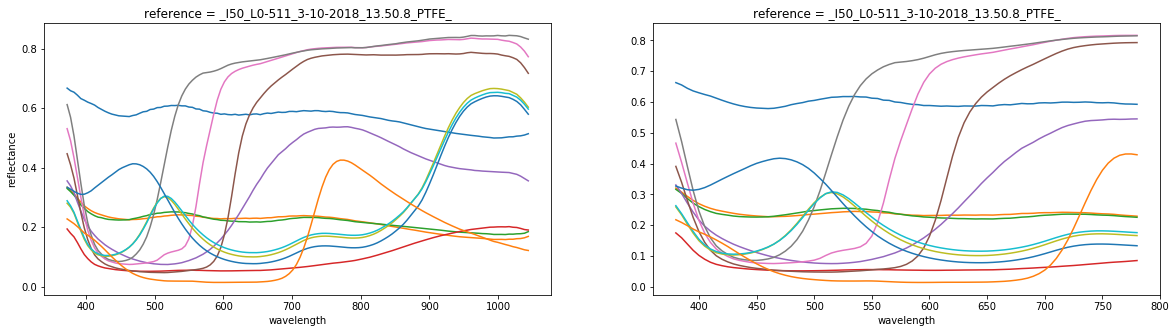

In [10]:
fig, ax = plt.subplots(ncols=2, figsize=(20,5))
measured.plot.line(x='wavelength', ax=ax[0],add_legend=False)
measurement_to_fit.plot.line(x='wavelength', ax=ax[1],add_legend=False)
plt.show()

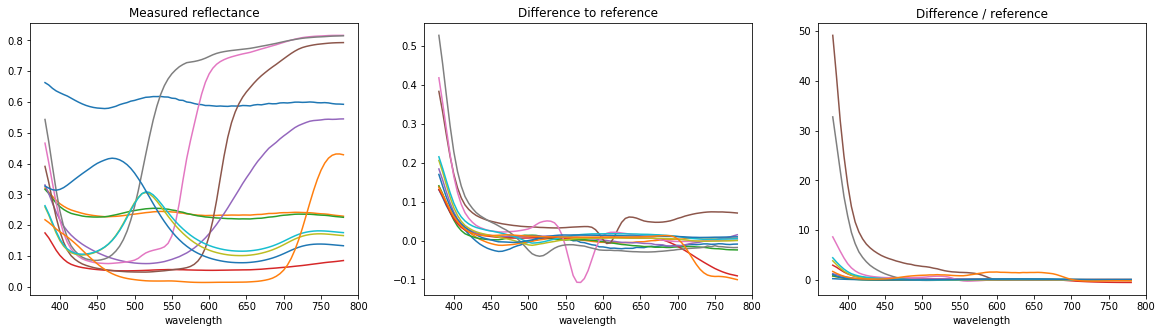

In [9]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))
measurement_to_fit.plot.line(x='wavelength', ax=ax[0],add_legend=False)
(measurement_to_fit - reference).plot.line(x='wavelength', add_legend=False, ax=ax[1])
((measurement_to_fit - reference)/reference).plot.line(x='wavelength', add_legend=False, ax=ax[2])
ax[0].set_title('Measured reflectance')
ax[1].set_title('Difference to reference')
ax[2].set_title('Difference / reference')
plt.show()

## Fit of coefficients
Fit coefficients C1-C5 for the model of the difference
$$
\Delta R = R_{ref} - R = C_1 + C_2 R + C_3 \frac{\delta R}{\delta \lambda} + C4 \frac{\delta^2 R}{\delta \lambda^2} + C_5 (1 - R)R
$$
from
> Germer et. al., ''Spectrophotometry: Accurate Measurement of Optical Properties of Materials'', 
>vol.46, p.394

In [7]:
coefs = fit_dataarray(measurement_to_fit, reference)

Add the modeled difference to the measured reflectance and compare with the reference data:

In [8]:
reconstruction = apply_model(measurement_to_fit, coefs)

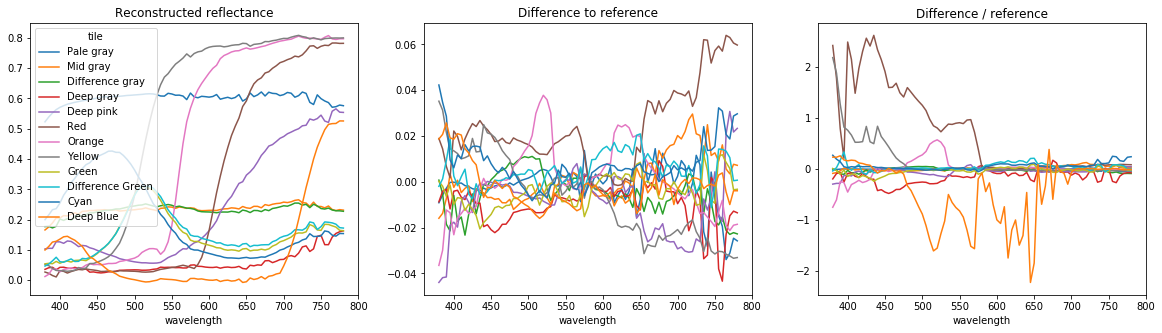

In [11]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))
reconstruction.plot.line(ax=ax[0], x='wavelength')
(reconstruction - reference).plot.line(ax=ax[1], add_legend=False, x='wavelength')
((reconstruction - reference)/reference).plot.line(ax=ax[2], add_legend=False, x='wavelength')
ax[0].set_title('Reconstructed reflectance')
ax[1].set_title('Difference to reference')
ax[2].set_title('Difference / reference')
plt.show()

In [12]:
reco_df = reconstruction.drop(['band', 'reference', 'filename']).to_dataset('tile').to_dataframe()
reco_df.to_csv('data/corrected_reflectances_malkin.csv')

### Coefficients
As defined by CZ in his Labview UI:

- C1: Offset
- C2: Span
- C3: Wavelength registration
- C4: Bandpass
- C5: Non-linearity

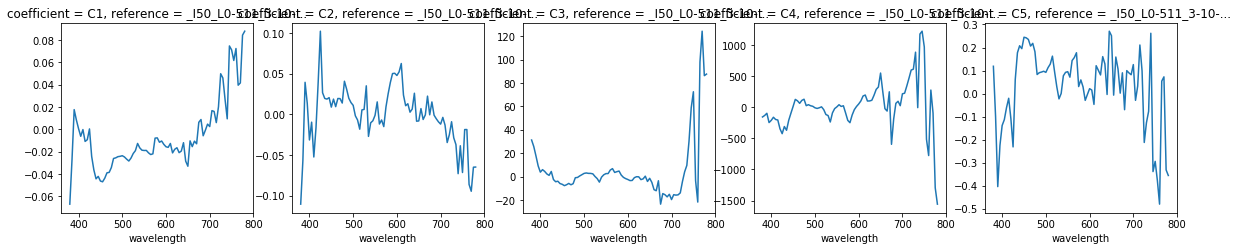

In [15]:
fig, ax = plt.subplots(ncols=5, figsize=(20,3.5))
for k, coef in enumerate(['C1', 'C2', 'C3', 'C4', 'C5']):
    coefs.sel(coefficient=coef).plot.line(x='wavelength', ax=ax[k])
plt.show()

## Second reference data

In [16]:
reference_cz = pd.read_excel('data/RSEX BEP1 CJZ measurements on Lambda 1050.xlsx',
                       sheet_name='reflectance', usecols='J:CM')
reference_cz.index = reference_cz['Artifact_Name']
reference_cz = reference_cz.drop(columns='Artifact_Name').transpose()
reference_cz.index = [int(s.split('_')[0]) for s in reference_cz.index]
reference_cz.index = reference_cz.index.rename('wavelength')
reference_cz = 0.01 * reference_cz.to_xarray().to_array('tile').drop(['PTFE', 'White', 'Black'], dim='tile')
reference_cz['tile'] = reference.tile

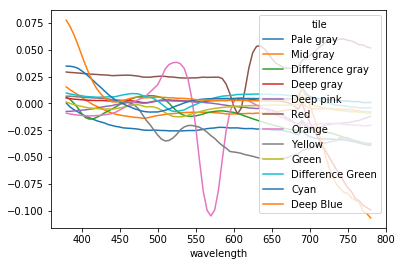

In [17]:
(reference_cz - reference).plot.line(x='wavelength')
plt.show()

In [18]:
cz_coefs = fit_dataarray(measurement_to_fit, reference_cz)

In [19]:
reconstruction_cz = apply_model(measurement_to_fit, cz_coefs)

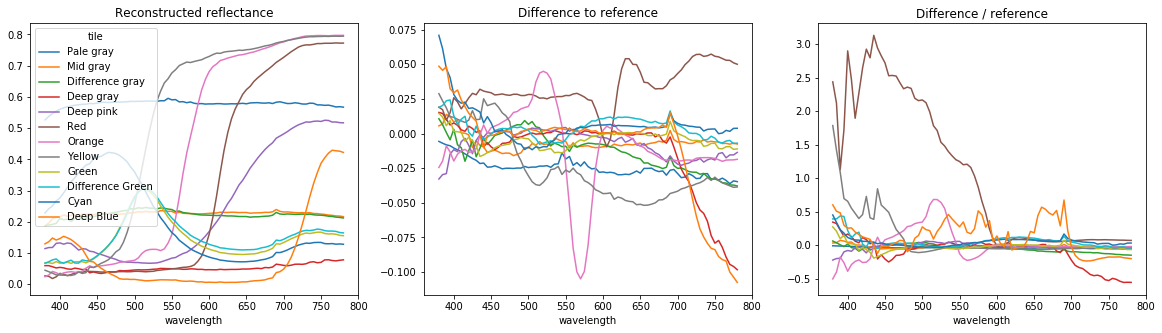

In [20]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))
reconstruction_cz.plot.line(ax=ax[0], x='wavelength')
(reconstruction_cz - reference).plot.line(ax=ax[1], add_legend=False, x='wavelength')
((reconstruction_cz - reference)/reference).plot.line(ax=ax[2], add_legend=False, x='wavelength')
ax[0].set_title('Reconstructed reflectance')
ax[1].set_title('Difference to reference')
ax[2].set_title('Difference / reference')
plt.show()

In [21]:
cz_reco_df = reconstruction.drop(['band', 'reference', 'filename']).to_dataset('tile').to_dataframe()
cz_reco_df.to_csv('data/corrected_reflectances_cz.csv')